Some weights of CvtForImageClassification were not initialized from the model checkpoint at microsoft/cvt-13 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([20]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 384]) in the checkpoint and torch.Size([20, 384]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Distribusi Kelas dalam Training Set:
Kelas 0: 114 sampel
Kelas 1: 108 sampel
Kelas 2: 108 sampel
Kelas 3: 108 sampel
Kelas 4: 108 sampel
Kelas 5: 102 sampel
Kelas 6: 108 sampel
Kelas 7: 108 sampel
Kelas 8: 108 sampel
Kelas 9: 108 sampel
Kelas 10: 108 sampel
Kelas 11: 102 sampel
Kelas 12: 108 sampel
Kelas 13: 108 sampel
Kelas 14: 108 sampel
Kelas 15: 108 sampel
Kelas 16: 108 sampel
Kelas 17: 108 sampel
Kelas 18: 108 sampel
Kelas 19: 108 sampel
Class Weights: tensor([0.9447, 0.9972, 0.9972, 0.9972, 0.9972, 1.0559, 0.9972, 0.9972, 0.9972,
        0.9972, 0.9972, 1.0559, 0.9972, 0.9972, 0.9972, 0.9972, 0.9972, 0.9972,
        0.9972, 0.9972], device='cuda:0')


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 1/100
Train Loss: 2.7553, Train Acc: 11.05%
Val Loss: 3.6343, Val Acc: 11.67%, Val F1 Score: 0.0757


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 2/100
Train Loss: 2.4547, Train Acc: 16.11%
Val Loss: 2.6132, Val Acc: 12.92%, Val F1 Score: 0.1022


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 3/100
Train Loss: 2.1155, Train Acc: 27.07%
Val Loss: 5.8424, Val Acc: 5.00%, Val F1 Score: 0.0048


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 4/100
Train Loss: 1.9033, Train Acc: 32.17%
Val Loss: 3.6209, Val Acc: 11.46%, Val F1 Score: 0.0619


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 5/100
Train Loss: 1.6929, Train Acc: 41.32%
Val Loss: 2.1842, Val Acc: 34.38%, Val F1 Score: 0.2616


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 6/100
Train Loss: 1.4926, Train Acc: 47.73%
Val Loss: 3.6744, Val Acc: 18.75%, Val F1 Score: 0.1516


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 7/100
Train Loss: 1.3622, Train Acc: 52.09%
Val Loss: 1.5142, Val Acc: 46.88%, Val F1 Score: 0.4346


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 8/100
Train Loss: 1.2279, Train Acc: 58.59%
Val Loss: 1.2996, Val Acc: 56.88%, Val F1 Score: 0.5586


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 9/100
Train Loss: 1.1201, Train Acc: 63.18%
Val Loss: 1.7054, Val Acc: 39.17%, Val F1 Score: 0.3744


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 10/100
Train Loss: 1.0196, Train Acc: 66.43%
Val Loss: 3.1536, Val Acc: 33.96%, Val F1 Score: 0.2816


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 11/100
Train Loss: 0.9509, Train Acc: 69.59%
Val Loss: 3.5174, Val Acc: 25.83%, Val F1 Score: 0.2249


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 12/100
Train Loss: 0.9745, Train Acc: 68.06%
Val Loss: 1.0272, Val Acc: 70.42%, Val F1 Score: 0.7065


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 13/100
Train Loss: 0.8358, Train Acc: 73.40%
Val Loss: 1.8195, Val Acc: 58.12%, Val F1 Score: 0.5592


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 14/100
Train Loss: 0.8556, Train Acc: 72.89%
Val Loss: 1.5236, Val Acc: 65.62%, Val F1 Score: 0.6404


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 15/100
Train Loss: 0.8357, Train Acc: 73.03%
Val Loss: 1.3829, Val Acc: 62.50%, Val F1 Score: 0.6077


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 16/100
Train Loss: 0.8656, Train Acc: 73.17%
Val Loss: 1.2328, Val Acc: 68.12%, Val F1 Score: 0.6833


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 17/100
Train Loss: 0.7516, Train Acc: 76.56%
Val Loss: 0.9000, Val Acc: 76.25%, Val F1 Score: 0.7577


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 18/100
Train Loss: 0.7176, Train Acc: 77.53%
Val Loss: 0.9479, Val Acc: 74.79%, Val F1 Score: 0.7437


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 19/100
Train Loss: 0.6627, Train Acc: 78.88%
Val Loss: 1.3818, Val Acc: 67.29%, Val F1 Score: 0.6638


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 20/100
Train Loss: 0.7508, Train Acc: 76.46%
Val Loss: 1.7809, Val Acc: 57.50%, Val F1 Score: 0.5589


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 21/100
Train Loss: 0.8042, Train Acc: 74.51%
Val Loss: 1.6051, Val Acc: 58.75%, Val F1 Score: 0.5796


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 22/100
Train Loss: 0.8222, Train Acc: 73.91%
Val Loss: 1.1890, Val Acc: 66.88%, Val F1 Score: 0.6721


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 23/100
Train Loss: 0.7416, Train Acc: 76.56%
Val Loss: 1.1553, Val Acc: 68.96%, Val F1 Score: 0.6952


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 24/100
Train Loss: 0.7093, Train Acc: 77.81%
Val Loss: 1.2327, Val Acc: 72.29%, Val F1 Score: 0.7224


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 25/100
Train Loss: 0.7083, Train Acc: 77.99%
Val Loss: 1.2501, Val Acc: 72.71%, Val F1 Score: 0.7164


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 26/100
Train Loss: 0.6978, Train Acc: 78.27%
Val Loss: 1.0646, Val Acc: 75.83%, Val F1 Score: 0.7624


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 27/100
Train Loss: 0.7018, Train Acc: 77.95%
Val Loss: 2.9653, Val Acc: 49.17%, Val F1 Score: 0.4987


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 28/100
Train Loss: 0.8124, Train Acc: 74.98%
Val Loss: 6.8598, Val Acc: 9.17%, Val F1 Score: 0.0800


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 29/100
Train Loss: 0.8013, Train Acc: 74.84%
Val Loss: 1.1204, Val Acc: 67.71%, Val F1 Score: 0.6759


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 30/100
Train Loss: 0.7295, Train Acc: 76.97%
Val Loss: 1.0034, Val Acc: 74.17%, Val F1 Score: 0.7444


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 31/100
Train Loss: 0.6780, Train Acc: 79.06%
Val Loss: 0.8580, Val Acc: 78.54%, Val F1 Score: 0.7918


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 32/100
Train Loss: 0.6311, Train Acc: 80.27%
Val Loss: 0.8546, Val Acc: 78.54%, Val F1 Score: 0.7938


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 33/100
Train Loss: 0.5661, Train Acc: 82.54%
Val Loss: 0.8664, Val Acc: 78.33%, Val F1 Score: 0.7908


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 34/100
Train Loss: 0.6233, Train Acc: 80.83%
Val Loss: 0.8644, Val Acc: 78.54%, Val F1 Score: 0.7924


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 35/100
Train Loss: 0.6788, Train Acc: 78.69%
Val Loss: 0.8729, Val Acc: 79.38%, Val F1 Score: 0.7998


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 36/100
Train Loss: 0.6394, Train Acc: 80.22%
Val Loss: 0.8633, Val Acc: 79.79%, Val F1 Score: 0.8042


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 37/100
Train Loss: 0.5931, Train Acc: 81.10%
Val Loss: 0.8560, Val Acc: 81.67%, Val F1 Score: 0.8235


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 38/100
Train Loss: 0.6059, Train Acc: 81.06%
Val Loss: 0.8847, Val Acc: 80.42%, Val F1 Score: 0.8115


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 39/100
Train Loss: 0.6515, Train Acc: 79.62%
Val Loss: 0.8654, Val Acc: 80.21%, Val F1 Score: 0.8105


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 40/100
Train Loss: 0.5544, Train Acc: 82.64%
Val Loss: 0.8614, Val Acc: 81.25%, Val F1 Score: 0.8187


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 41/100
Train Loss: 0.6275, Train Acc: 80.50%
Val Loss: 0.8638, Val Acc: 81.46%, Val F1 Score: 0.8211


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 42/100
Train Loss: 0.6371, Train Acc: 79.62%
Val Loss: 0.8799, Val Acc: 81.25%, Val F1 Score: 0.8181


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 43/100
Train Loss: 0.5955, Train Acc: 81.06%
Val Loss: 0.8417, Val Acc: 81.04%, Val F1 Score: 0.8170


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 44/100
Train Loss: 0.6106, Train Acc: 80.87%
Val Loss: 0.8929, Val Acc: 80.21%, Val F1 Score: 0.8077


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 45/100
Train Loss: 0.6423, Train Acc: 79.81%
Val Loss: 0.8906, Val Acc: 79.79%, Val F1 Score: 0.8038


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 46/100
Train Loss: 0.6030, Train Acc: 80.78%
Val Loss: 0.8835, Val Acc: 80.62%, Val F1 Score: 0.8118


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 47/100
Train Loss: 0.5809, Train Acc: 81.71%
Val Loss: 0.8729, Val Acc: 81.46%, Val F1 Score: 0.8204


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 48/100
Train Loss: 0.5803, Train Acc: 81.80%
Val Loss: 0.8652, Val Acc: 81.04%, Val F1 Score: 0.8163


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 49/100
Train Loss: 0.6085, Train Acc: 80.92%
Val Loss: 0.8735, Val Acc: 80.83%, Val F1 Score: 0.8133


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 50/100
Train Loss: 0.6134, Train Acc: 81.01%
Val Loss: 0.8949, Val Acc: 80.21%, Val F1 Score: 0.8084


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 51/100
Train Loss: 0.6282, Train Acc: 80.50%
Val Loss: 0.9080, Val Acc: 80.83%, Val F1 Score: 0.8138


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 52/100
Train Loss: 0.6044, Train Acc: 81.43%
Val Loss: 0.9463, Val Acc: 79.79%, Val F1 Score: 0.8016


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 53/100
Train Loss: 0.5813, Train Acc: 81.52%
Val Loss: 0.9165, Val Acc: 78.96%, Val F1 Score: 0.7932


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 54/100
Train Loss: 0.6304, Train Acc: 80.32%
Val Loss: 0.9268, Val Acc: 79.79%, Val F1 Score: 0.8007


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 55/100
Train Loss: 0.6205, Train Acc: 80.92%
Val Loss: 0.9594, Val Acc: 80.62%, Val F1 Score: 0.8106


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 56/100
Train Loss: 0.5754, Train Acc: 82.08%
Val Loss: 0.9235, Val Acc: 79.58%, Val F1 Score: 0.7995


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Early stopping setelah epoch 57 karena tidak ada peningkatan akurasi validasi.


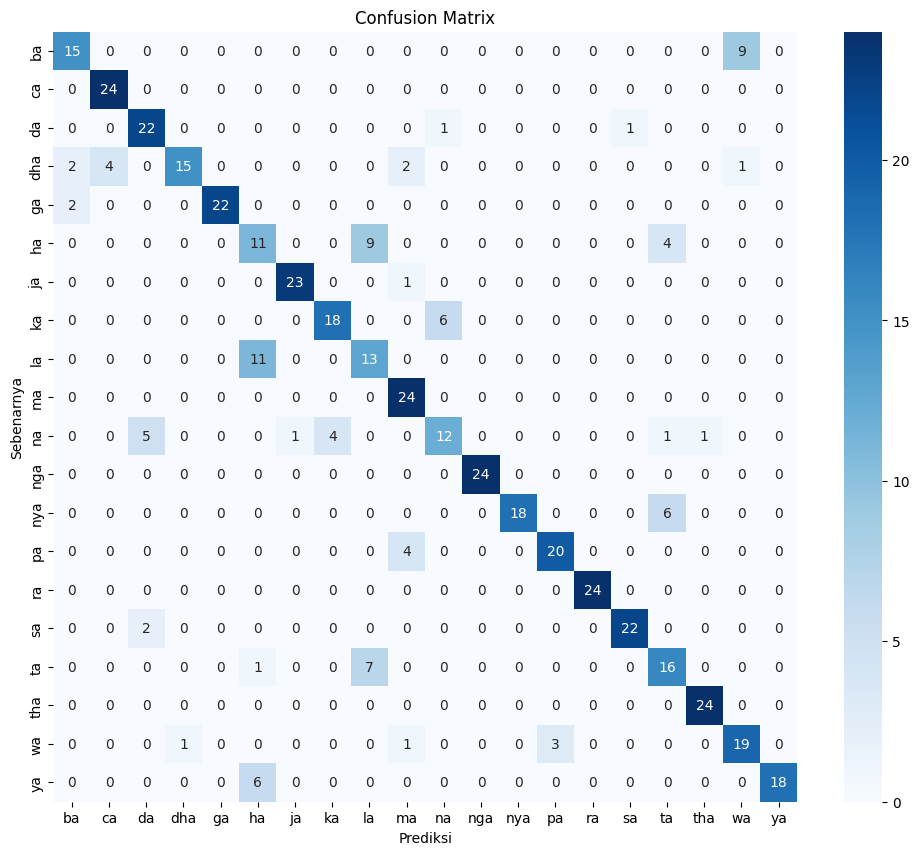

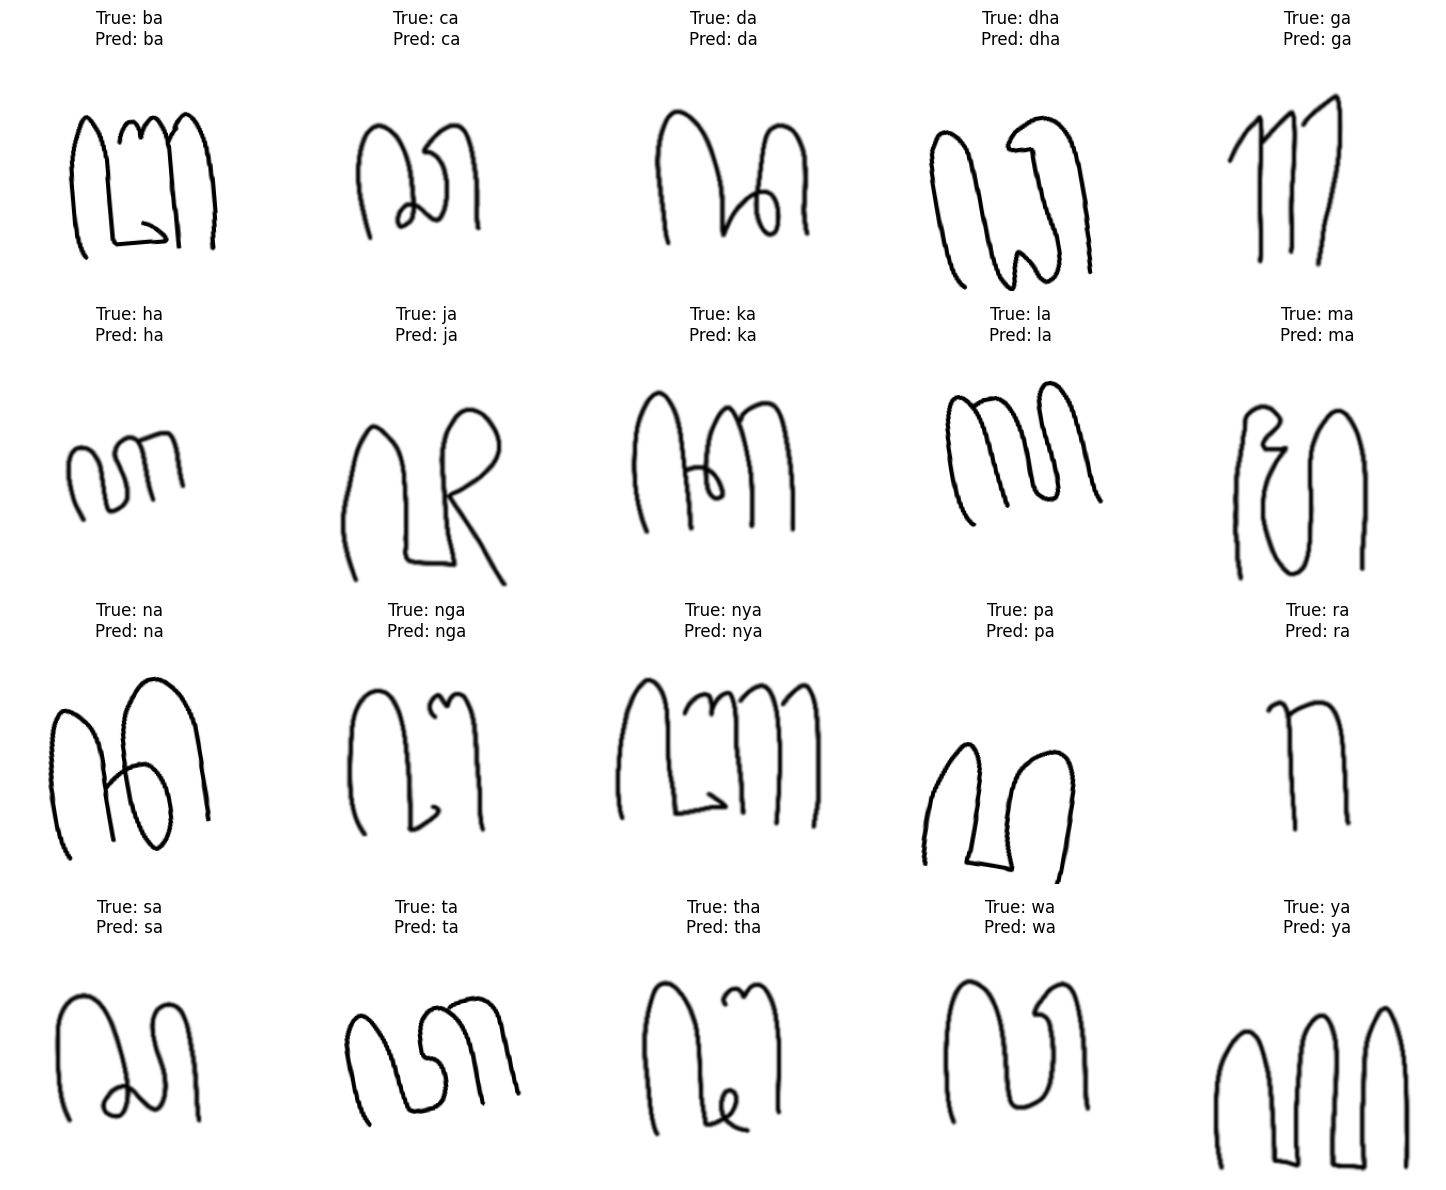

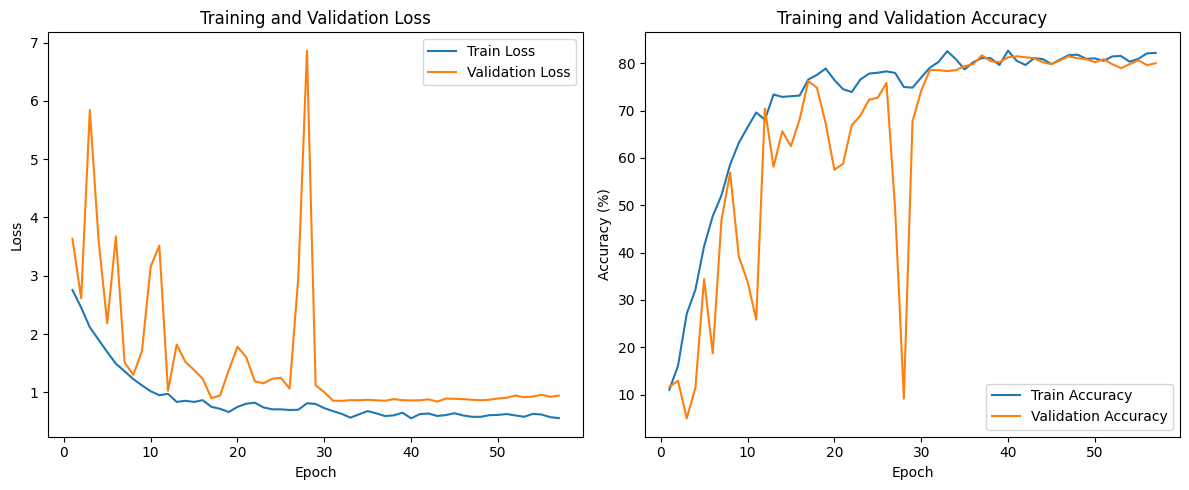

Classification Report untuk Training Set:


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


              precision    recall  f1-score   support

          ba       1.00      1.00      1.00       114
          ca       1.00      1.00      1.00       108
          da       1.00      1.00      1.00       108
         dha       1.00      1.00      1.00       108
          ga       1.00      1.00      1.00       108
          ha       1.00      1.00      1.00       102
          ja       1.00      1.00      1.00       108
          ka       1.00      1.00      1.00       108
          la       1.00      1.00      1.00       108
          ma       1.00      1.00      1.00       108
          na       1.00      1.00      1.00       108
         nga       1.00      1.00      1.00       102
         nya       1.00      1.00      1.00       108
          pa       1.00      1.00      1.00       108
          ra       1.00      1.00      1.00       108
          sa       1.00      1.00      1.00       108
          ta       1.00      1.00      1.00       108
         tha       1.00    

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


              precision    recall  f1-score   support

          ba       0.79      0.62      0.70        24
          ca       0.86      1.00      0.92        24
          da       0.76      0.92      0.83        24
         dha       0.94      0.62      0.75        24
          ga       1.00      0.92      0.96        24
          ha       0.38      0.46      0.42        24
          ja       0.96      0.96      0.96        24
          ka       0.82      0.75      0.78        24
          la       0.45      0.54      0.49        24
          ma       0.75      1.00      0.86        24
          na       0.63      0.50      0.56        24
         nga       1.00      1.00      1.00        24
         nya       1.00      0.75      0.86        24
          pa       0.87      0.83      0.85        24
          ra       1.00      1.00      1.00        24
          sa       0.96      0.92      0.94        24
          ta       0.59      0.67      0.63        24
         tha       0.96    

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR, StepLR
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from transformers import AutoConfig, CvtForImageClassification, AutoImageProcessor
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
from PIL import Image, UnidentifiedImageError
import os
from sklearn.metrics import confusion_matrix, f1_score, classification_report
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter
import seaborn as sns
import random
from collections import Counter

# Set seed for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 16
NUM_CLASSES = 20
EPOCHS = 100
LEARNING_RATE = 1e-3  # Meningkatkan learning rate
WEIGHT_DECAY = 0.00002683
IMAGE_SIZE = 224
DATASET_PATH = '/kaggle/input/d/phiard/aksara-jawa/v3/v3'  # Pastikan path ini benar

# Konfigurasi model
config = AutoConfig.from_pretrained("microsoft/cvt-13")
config.num_labels = NUM_CLASSES
config.hidden_dropout_prob = 0.1  # Mengurangi dropout

model = CvtForImageClassification.from_pretrained(
    "microsoft/cvt-13", config=config, ignore_mismatched_sizes=True
).to(device)

# Pastikan semua parameter dioptimalkan
for param in model.parameters():
    param.requires_grad = True

# Transformasi untuk data pelatihan tanpa augmentasi awal
train_transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.CenterCrop(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Transformasi untuk data validasi tanpa augmentasi
val_transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.CenterCrop(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

class CustomImageFolder(Dataset):
    def __init__(self, root, transform=None):
        self.samples = []
        self.targets = []
        self.transform = transform
        self.classes, self.class_to_idx = self._find_classes(root)
        self.num_classes = len(self.classes)

        for target_class in sorted(self.class_to_idx.keys()):
            class_index = self.class_to_idx[target_class]
            target_dir = os.path.join(root, target_class)
            if not os.path.isdir(target_dir):
                continue
            for root_, _, fnames in sorted(os.walk(target_dir, followlinks=True)):
                for fname in sorted(fnames):
                    path = os.path.join(root_, fname)
                    try:
                        with Image.open(path) as img:
                            img.verify()  # Verifikasi integritas gambar
                        self.samples.append((path, class_index))
                        self.targets.append(class_index)
                    except (UnidentifiedImageError, OSError):
                        print(f"Gambar korup dilewati: {path}")
                        continue

    def __getitem__(self, index):
        path, target = self.samples[index]
        with Image.open(path) as sample:
            sample = sample.convert('RGB')

        if self.transform:
            sample = self.transform(sample)

        return sample, target

    def __len__(self):
        return len(self.samples)

    def _find_classes(self, dir):
        classes = [d.name for d in os.scandir(dir) if d.is_dir()]
        classes.sort()
        class_to_idx = {classes[i]: i for i in range(len(classes))}
        return classes, class_to_idx

train_dir = os.path.join(DATASET_PATH, 'train')
val_dir = os.path.join(DATASET_PATH, 'val')

# Membuat dataset dengan transformasi yang sesuai
train_dataset = CustomImageFolder(train_dir, transform=train_transform)
val_dataset = CustomImageFolder(val_dir, transform=val_transform)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)

# Verifikasi distribusi kelas
counter = Counter(train_dataset.targets)
print("Distribusi Kelas dalam Training Set:")
for cls, count in counter.items():
    print(f"Kelas {cls}: {count} sampel")

# Menghitung class weights hanya jika distribusi kelas tidak seimbang secara signifikan
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_dataset.targets),
    y=train_dataset.targets
)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
print(f"Class Weights: {class_weights}")

# Definisikan loss function tanpa label smoothing
criterion = nn.CrossEntropyLoss(weight=class_weights, label_smoothing=0.0)

# Definisikan optimizer dengan learning rate yang lebih tinggi
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

# Menggunakan scheduler yang lebih lambat
scheduler = StepLR(optimizer, step_size=30, gamma=0.1)

def train_epoch(model, loader, optimizer, criterion):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    for data, target in loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data).logits
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        _, predicted = output.max(1)
        correct += predicted.eq(target).sum().item()
        total += target.size(0)
    return total_loss / len(loader), 100. * correct / total

def validate(model, loader, criterion):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    all_targets = []
    all_predictions = []
    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            output = model(data).logits
            loss = criterion(output, target)
            total_loss += loss.item()
            _, predicted = output.max(1)
            correct += predicted.eq(target).sum().item()
            total += target.size(0)
            all_targets.extend(target.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
    f1 = f1_score(all_targets, all_predictions, average='weighted')
    return total_loss / len(loader), 100. * correct / total, f1, all_targets, all_predictions

writer = SummaryWriter()
train_losses = []
train_accs = []
val_losses = []
val_accs = []
val_f1_scores = []
patience = 20  # Meningkatkan patience untuk early stopping
counter = 0
best_val_acc = 0

for epoch in range(EPOCHS):
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion)
    val_loss, val_acc, val_f1, all_targets, all_predictions = validate(model, val_loader, criterion)
    
    # Menyimpan metrik
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    val_f1_scores.append(val_f1)

    # Logging ke TensorBoard
    writer.add_scalars('Loss', {'Train': train_loss, 'Val': val_loss}, epoch)
    writer.add_scalars('Accuracy', {'Train': train_acc, 'Val': val_acc}, epoch)
    writer.add_scalar('F1_Score/Val', val_f1, epoch)

    # Menyimpan model terbaik
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_cvt_model.pth")
        counter = 0  # Reset counter jika ada peningkatan
    else:
        counter += 1

    # Early stopping
    if counter >= patience:
        print(f"Early stopping setelah epoch {epoch+1} karena tidak ada peningkatan akurasi validasi.")
        break

    # Menampilkan progres
    print(f"Epoch {epoch+1}/{EPOCHS}")
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%, Val F1 Score: {val_f1:.4f}")

    # Update scheduler
    scheduler.step()

writer.close()

# Plot Confusion Matrix untuk Validasi
def plot_confusion_matrix(targets, predictions, class_names):
    cm = confusion_matrix(targets, predictions)
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Prediksi")
    plt.ylabel("Sebenarnya")
    plt.title("Confusion Matrix")
    plt.show()

plot_confusion_matrix(all_targets, all_predictions, train_dataset.classes)

# Tampilkan prediksi per kelas
def show_predictions_per_class(model, dataset, num_classes=20, cols=5):
    model.eval()
    rows = (num_classes + cols - 1) // cols
    fig, axs = plt.subplots(rows, cols, figsize=(15, 3 * rows))
    axs = axs.flatten()

    class_images = {i: None for i in range(num_classes)}

    for i in range(len(dataset)):
        image, label = dataset[i]
        image = image.unsqueeze(0).to(device)
        with torch.no_grad():
            output = model(image).logits
            _, predicted = output.max(1)
            if class_images[label] is None and predicted.item() == label:
                class_images[label] = (image.squeeze().cpu(), label, predicted.item())
                if all(value is not None for value in class_images.values()):
                    break

    for i in range(num_classes):
        ax = axs[i]
        if class_images[i] is not None:
            img, true_label, pred_label = class_images[i]
            # Denormalisasi gambar
            img = img * torch.tensor([0.229, 0.224, 0.225]).view(3,1,1) + torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
            img = img.permute(1, 2, 0).numpy()
            img = np.clip(img, 0, 1)
            ax.imshow(img)
            ax.set_title(f"True: {train_dataset.classes[true_label]}\nPred: {train_dataset.classes[pred_label]}")
            ax.axis('off')
        else:
            ax.text(0.5, 0.5, 'No Prediction', ha='center', va='center')
            ax.axis('off')

    for j in range(num_classes, len(axs)):
        axs[j].axis('off')
    
    plt.tight_layout()
    plt.show()

show_predictions_per_class(model, val_dataset)

# Plot Loss dan Akurasi
plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot Akurasi
plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_accs) + 1), train_accs, label='Train Accuracy')
plt.plot(range(1, len(val_accs) + 1), val_accs, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Evaluasi Tambahan: Classification Report
def classification_metrics(loader):
    model.eval()
    all_targets = []
    all_predictions = []
    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            output = model(data).logits
            _, predicted = torch.max(output, 1)
            all_targets.extend(target.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
    print(classification_report(all_targets, all_predictions, target_names=train_dataset.classes))

print("Classification Report untuk Training Set:")
classification_metrics(train_loader)

print("Classification Report untuk Validation Set:")
classification_metrics(val_loader)
